# Assignment 4 - Parameter Identification

# Finding Stiffness and Dampening parameters of a flexure joint

## Goal of the Experiment
The goal of this experiment is to determine the stiffness (\(k\)) and damping (\(b\)) parameters of cardstock material. By conducting controlled oscillation tests on the cardstock, capturing real-world data, and comparing it to simulated data in MuJoCo, we aim to identify parameters that best approximate the cardstock’s behavior.


## Data Collection Process

### Experimental Setup
- A cardstock with a weight of 140 gsm was placed over the edge of a table.
- A 1g weight was positioned at the edge of the cardstock, creating a cantilever-like setup with support given till the experiment begins.
- The weight was then dropped, initiating oscillations in the cardstock, which were recorded as it oscillated until coming to rest.

### Data Capture
- **Software Used:** The oscillation data was captured using the software *Tracker*, which tracked the x, y, and z positions of the weight at each timestep.
- **Data Collected:** For each timestep, the software recorded the x, y, and z values, representing the motion in three dimensions.


The image below shows the tracker software stacking the black dot and giving the x,y coordinates of the point at various timesteps.

![Tracker Software](image.png)


In [1]:
import os
import mujoco
import numpy
import mediapy as media
import matplotlib.pyplot as plt
import scipy.optimize as so
import scipy.interpolate as si
import pandas as pd

from scipy.signal import find_peaks

In [2]:
# Raw data collected

df=pd.read_csv('/home/pranaypalem/Documents/Foldable Robotics/Project/Experiment_long_data_120_360.csv', sep=',')
dfFull = pd.read_csv('/home/pranaypalem/Documents/Foldable Robotics/Project/Experiment_long_data_0_594.csv', sep=',')
df

,t,x,y
0,0.000000,0.087515,-0.146932
1,0.033611,0.095152,-0.143466
2,0.067222,0.103068,-0.139386
3,0.100833,0.110226,-0.135236
4,0.134444,0.115923,-0.131405
...,...,...,...
236,7.932222,0.100671,-0.140845
237,7.965833,0.101070,-0.140646
238,7.999444,0.101384,-0.140530
239,8.033056,0.101558,-0.140344


### Interpolation of Data Points
- The captured x, y, and z data points were interpolated to form continuous functions \(f(x)\) and \(f(y)\), enabling a smooth representation of the oscillatory motion.

### Assumptions
- The cardstock is assumed to have uniform material properties (stiffness and damping) across its length.
- Air resistance and minor external factors are considered negligible, focusing solely on the intrinsic material properties.

---

In [3]:
#x = df.x.astype('float64').to_numpy()
x = df.x.to_numpy()
y = df.y.to_numpy()
t = df.t.to_numpy()

xFull_data = dfFull.x.to_numpy()
yFull_data = dfFull.y.to_numpy()
tFull_data = dfFull.t.to_numpy()

xy = numpy.array([x,y]).T
f = si.interp1d(t,xy.T,fill_value='extrapolate',kind='quadratic')
new_t = numpy.r_[0:t[-1]:0.002]
new_t = new_t[1:] # removing timestep = 0

len(new_t)

4033

In [4]:
# making an array to adjust x,y,z as in mujoco

f_result = numpy.array([[f(t_val)[0], 0, f(t_val)[1]] for t_val in new_t])
f_result.shape

(4033, 3)

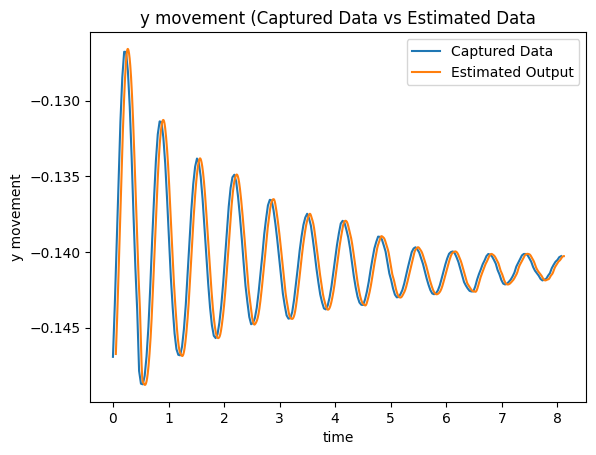

In [5]:
# checking if the function f models the captured data accurately

plt.figure()
plt.plot(t,y, label='Captured Data')
plt.plot(new_t+0.05,f(new_t)[1], label='Estimated Output') # plotting with offset for visual purposes
plt.xlabel('time')
plt.ylabel('y movement')
plt.title('y movement (Captured Data vs Estimated Data')
plt.legend()


In [6]:
# Adding variable elements to the code

start_frames = 120 # as per the tracker data
end_frames = 360 # as per the tracker data

start_sec = start_frames / 30
end_sec = end_frames / 30

start_data = int((start_frames*500)/30)
end_data = int((end_frames*500)/30)


In [7]:
gsm = 140
length_long = 0.0254 * 8.5 #8.5 inch end to end, but 7.28 till point tracked
length_short = 0.0254 * 6.5 #6.5 inch in m

l_selected = length_long 

width = 0.0254 * 2 #2 inch in m
thickness = 0.00016 # in m
mass_paper = (gsm*length_long*width) * 0.001 # Kg conversion

In [8]:
# length_short = 0.0254 * 6.5 #6.5 inch in m
# width = 0.0254 * 2.3 #2 inch in m
# thickness = 0.00016 # in m
# mass_paper = (gsm*length_long*width) * 0.001 # Kg conversion
# mass_paper

In [9]:
k_total = 1e-3  # for 8.5 inch length 
b_total = 1.92*1e-5 # for 8.5 inch length


### Simulation Model
- **Platform:** The MuJoCo simulation environment was used to replicate the real-world experiment.
- **Model Specifications:** The cardstock in the simulation was modeled with identical dimensions (length, width, and thickness) and mass as the real-world sample.
- **Parameter Fitting Goal:** By matching the simulated oscillation pattern with the experimental data, we aimed to fine-tune the stiffness and damping parameters to achieve a realistic representation.

---

In [10]:
main_template = """
<mujoco>
    <option gravity="0 0 -9.81">
        <flag contact="disable"/>
    </option>
    <worldbody>
        <light name="top" pos="0 0 1"/>
        <body name="body_1" pos="{l1_2} 0 0">
            <joint name="joint_1" type="hinge" axis="0 1 0" pos="-{l1_2} 0 0" stiffness="{k}" damping="{b}"/>
            <geom type="box" size="{l1_2} 0.0508 0.00016" pos="{l1_2} 0 0" rgba="1 0 0 1" mass="{m}"/>
            {inner}
        </body>
    </worldbody>
</mujoco>
"""

body_template = '''
<body name="body_{ii}" pos="{l1} 0 0">
    <joint name="joint_{ii}" type="hinge" axis="0 1 0" pos="0 0 0" stiffness="{k}" damping="{b}"/>
    <geom type="box" size="{l1_2} 0.0508 0.00016" pos="{l1_2} 0 0" rgba="1 0 0 1" mass="{m}"/>
    {inner}
</body>
'''

test_point='''
<geom type="sphere" size="0.0254" pos="{l1} 0 0" rgba="0 0 1 1" mass="0.001"/>
'''

In [11]:
def run_sim(num_joints,k_i,b_i,m_total,render=False,show_video=False):
    n_joints = num_joints
    n_bodies = n_joints
    l = l_selected  # Total Length in m 
    l_i=l/n_bodies
    m_i=m_total/n_bodies
    body_numbers = numpy.r_[n_bodies:1:-1]
    s=''
    for item in body_numbers:
        if item == body_numbers.max():
            s = body_template.format(inner=test_point.format(l1='{l1}'),ii=item, l1='{l1}',l1_2='{l1_2}',b='{b}',k='{k}',m='{m}')
        else:
            s = body_template.format(inner=s,ii=item,l1='{l1}',l1_2='{l1_2}', b='{b}',k='{k}',m='{m}')
        
    s=main_template.format(inner = s,l1='{l1}',l1_2='{l1_2}',b='{b}',k='{k}',m='{m}')
    
    xml = s.format(l1=l_i,l1_2=l_i/2,k=k_i,b=b_i,m=m_i)
    
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model)
    
    duration = 20 # (seconds)
    framerate = 30 # (Hz)
    
    q = []
    t = []
    xyz = []
    frames = []

    qFull = []
    tFull = []
    xyzFull = []
    
    mujoco.mj_resetData(model, data)

    ### Setting initial values
    #initial_pos = numpy.array([0.185 , 0.0 ,-0.025])
    #initial_w = numpy.array([0.0 , 0.8 ,0.0])
    #data.qpos[:len(initial_pos)] = initial_pos
    #data.qvel[:len(initial_w)] = initial_w
    
    while data.time < duration:
        
        mujoco.mj_step(model, data)

        # qFull.append(data.qpos.copy())
        # xyzFull.append(data.xpos.copy())
        # tFull.append(data.time)
        
        if start_sec < data.time <= end_sec+0.0666:  # starting and ending collection of data for only a portion of the simulation + offset of 0.0666 seconds as seen in the code "DataPrinting.ipynb"
            q.append(data.qpos.copy())
            xyz.append(data.xpos.copy())
            t.append(data.time)
            if render:
                if len(frames) < (data.time - start_sec) * framerate:
                    renderer.update_scene(data)
                    pixels = renderer.render()
                    frames.append(pixels)
        
    if render:
        if show_video:
            media.show_video(frames, fps=framerate)
            
    t = numpy.array(t)
    xyz = numpy.array(xyz)

    tFull = numpy.array(tFull)
    xyzFull = numpy.array(xyzFull)

    #print(q)
    if render:
        return t, xyz, frames 
    else:
        return t, xyz 
        

(np.float64(-0.5), np.float64(319.5), np.float64(239.5), np.float64(-0.5))

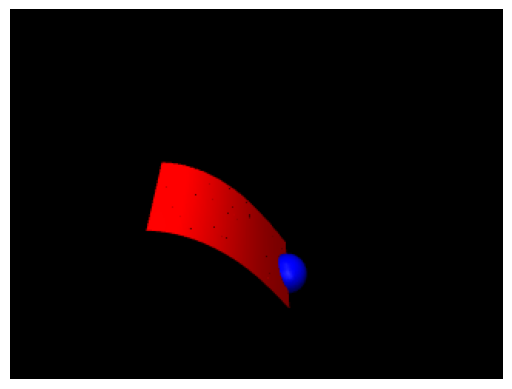

In [12]:
nn = 100
k_ii = nn * k_total
b_ii = nn* b_total 
t,xyz_100_elements,frames_100_elements = run_sim(num_joints = nn,k_i = k_ii, b_i = b_ii, m_total= mass_paper,render=True,show_video=True)
plt.imshow(frames_100_elements[12])
plt.axis('off')

In [13]:
xyz_100_elements.shape

(4033, 101, 3)

In [14]:
#t = t[:len(new_t)]
#t.shape

In [15]:
#sim_t = t - start_sec
#sim_t

(np.float64(-0.5), np.float64(319.5), np.float64(239.5), np.float64(-0.5))

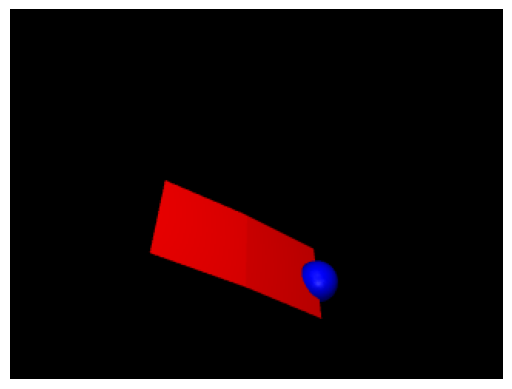

In [16]:
nn = 2
k_ii = nn * k_total
b_ii = nn* b_total 
t,xyz_2_elements,frames_2_elements = run_sim(num_joints = nn,k_i = k_ii, b_i = b_ii, m_total= mass_paper,render=True,show_video=True)
plt.imshow(frames_2_elements[12])
plt.axis('off')

In [17]:
t = t[:len(new_t)]
t.shape

(4033,)

In [18]:
sim_t = t - start_sec
sim_t

array([2.000e-03, 4.000e-03, 6.000e-03, ..., 8.062e+00, 8.064e+00,
       8.066e+00])

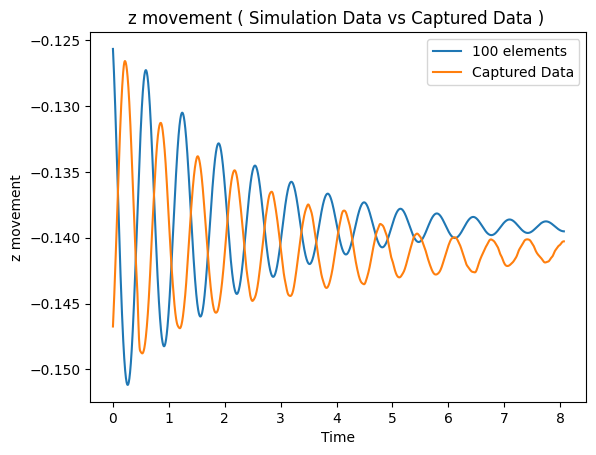

In [19]:
plt.figure()
plt.plot(sim_t,xyz_100_elements[:,-1,2],label='100 elements')
#plt.plot(sim_t,xyz_2_elements[:,-1,2],label='2 elements')
plt.plot(new_t,f_result[:,2],label='Captured Data')
plt.title('z movement ( Simulation Data vs Captured Data ) ')
plt.xlabel('Time')
plt.ylabel('z movement')
plt.legend()

## Data Fitting Process

### Initial Alignment
- **First Peak Matching:** To ensure consistency in the oscillation phases between the real-world data and the simulation, we aligned the first peaks of both datasets as the starting point.


In [20]:

#Time adjustment to align peaks
peaks_element, _ = find_peaks(xyz_100_elements[:,-1,2])
peaks_f, _ = find_peaks(f_result[:,2])    
z_new = xyz_100_elements[peaks_element[0]:,-1,2] #selecting peak 0
f_result_z = f_result[peaks_f[0]:,2] #selecting peak 0
if len(z_new) <= len(f_result_z):
    f_result_z = f_result_z[:len(z_new)]
else:
    z_new =  z_new[:len(f_result_z)]

adjusted_t = numpy.arange(0,len(z_new)*0.002,0.002)
adjusted_t.shape

(3739,)

- **Amplitude Correction**: I corrected the amplitude of the simulated oscillations by calculating the difference between the experimental data and the simulated data. The amplitude was adjusted in the simulation to match the experimental oscillation peak.


In [21]:
# Z Adjustment

diff = abs(f_result_z[-1]) - abs(z_new[-1])

if f_result_z[-1] >= z_new[-1]:
    z_new = z_new + diff
else:
    z_new = z_new - diff
    


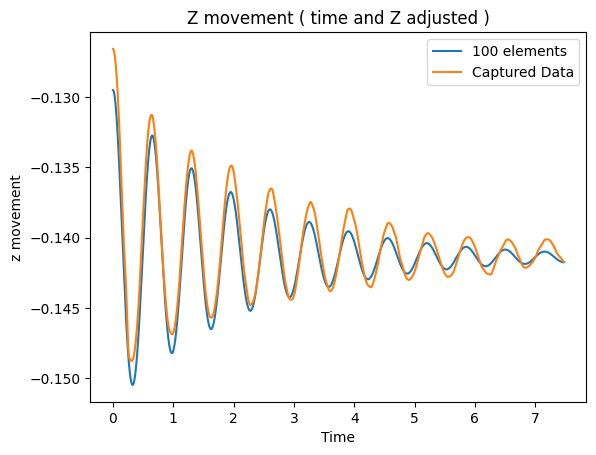

In [22]:
plt.figure()
plt.plot(adjusted_t,z_new,label='100 elements')
plt.plot(adjusted_t,f_result_z,label='Captured Data')
plt.title('Z movement ( time and Z adjusted )')
plt.xlabel('Time')
plt.ylabel('z movement')
plt.legend()

In [23]:
## Testing with time adjustment to align peaks

In [24]:
ini = [1e-3,1.95*1e-5]
results = []
num_elements_to_try = numpy.array([2,3,4,5,6,8,12,25,50,75,100])

def calc_error(x,nn):
    k,b = x
    t,xyz_sim = run_sim(nn,k_i=k,b_i=b,m_total=mass_paper)
    t = t[:len(new_t)]
    sim_t = t - start_sec

    #### Time adjustment
    peaks_element, _ = find_peaks(xyz_sim[:,-1,2])
    peaks_f, _ = find_peaks(f_result[:,2])    
    z_new = xyz_sim[peaks_element[0]:,-1,2]
    f_result_z = f_result[peaks_f[0]:,2]
    if len(z_new) <= len(f_result_z):
        f_result_z = f_result_z[:len(z_new)]
    else:
        z_new =  z_new[:len(f_result_z)] 

    
    #### Z Adjustment
    diff = abs(f_result_z[-1]) - abs(z_new[-1])
    
    if f_result_z[-1] >= z_new[-1]:
        z_new = z_new + diff
    else:
        z_new = z_new - diff

    # #### Z Adjustment v2
    # diff = abs(f_result_z[0]) - abs(z_new[0])
    
    # if f_result_z[0] >= z_new[0]:
    #     z_new = z_new + diff
    # else:
    #     z_new = z_new - diff


    mse = numpy.mean((z_new - f_result_z) ** 2)
    return mse

Text(0, 0.5, 'Error (mse)')

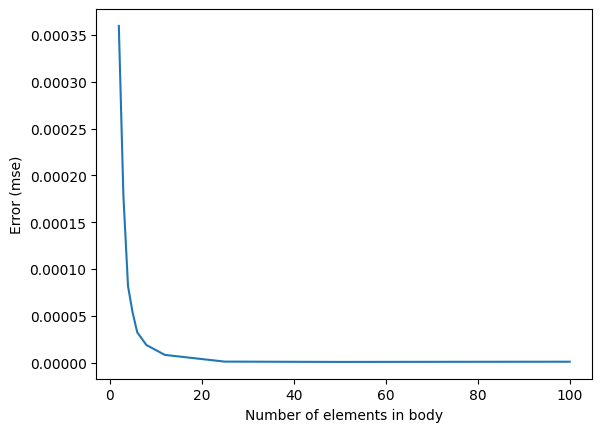

In [25]:
error_agnostic = []
for nn in num_elements_to_try:
    k_ii = nn * k_total
    b_ii = nn * b_total
    error = calc_error((k_ii,b_ii),nn)
    error_agnostic.append(error)

error_agnostic = numpy.array(error_agnostic)
plt.plot(num_elements_to_try,error_agnostic)
plt.xlabel('Number of elements in body')
plt.ylabel('Error (mse)')

### Optimization Process
- **Optimization Tool:** We used the `scipy.optimize.minimize` function in Python to minimize the mean square error (MSE) between the experimental and simulated datasets by adjusting the stiffness and damping values.
- **Objective Function:** The MSE between the experimental and simulated x, y, z values was set as the objective function for minimization.


In [26]:
for nn in num_elements_to_try:
    def calc_error_internal(x):
        return calc_error(x,nn)

    ub1 = 1e-3 + 1e-8
    lb1 = 1e-3 - 1e-8

    ub2 = 1.95e-5 + 1e-9
    lb2 = 1.95e-5 - 1e-9
    
    result = so.minimize(calc_error_internal,ini,method='powell', bounds=((lb1,ub1),(lb2,ub2)))
    results.append([nn,*result.x,result.fun])
    #ini = result.x
    ini = [1e-3,1.95e-5]
    print(results[-1])

[np.int64(2), np.float64(0.000999997639320225), np.float64(1.94997639320225e-05), np.float64(0.0006998050642363419)]
[np.int64(3), np.float64(0.000999997639320225), np.float64(1.94997639320225e-05), np.float64(0.003412769344764767)]
[np.int64(4), np.float64(0.000999997639320225), np.float64(1.94997639320225e-05), np.float64(0.005170212925865457)]
[np.int64(5), np.float64(0.000999997639320225), np.float64(1.94997639320225e-05), np.float64(0.006803116374252626)]
[np.int64(6), np.float64(0.000999997639320225), np.float64(1.94997639320225e-05), np.float64(0.007959554207083658)]
[np.int64(8), np.float64(0.000999997639320225), np.float64(1.94997639320225e-05), np.float64(0.005086159697105161)]
[np.int64(12), np.float64(0.000999997639320225), np.float64(1.94997639320225e-05), np.float64(0.007038352287743427)]
[np.int64(25), np.float64(0.000999997639320225), np.float64(1.94997639320225e-05), np.float64(0.007573511089817086)]
[np.int64(50), np.float64(0.000999997639320225), np.float64(1.9499763

### Final Output
- After optimization, we obtained the values for \(k\) (stiffness) and \(b\) (damping) that best approximated the real-world data, resulting in a reliable representation of the cardstock material’s oscillatory behavior.


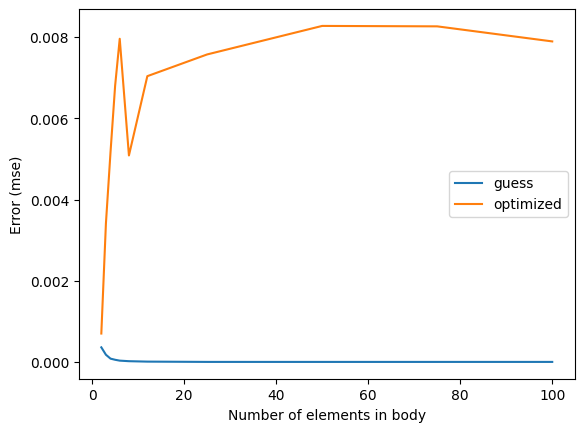

In [27]:
results = numpy.array(results)
plt.plot(num_elements_to_try,error_agnostic,label="guess")
plt.plot(results[:,0],results[:,3],label='optimized')
plt.xlabel('Number of elements in body')
plt.ylabel('Error (mse)')
plt.legend()


- **Optimization Results**: The minimization algorithm provided the optimal values of k and b that minimized the mean square error between the experimental and simulation data, yielding a close approximation of the cardstock's physical parameters.

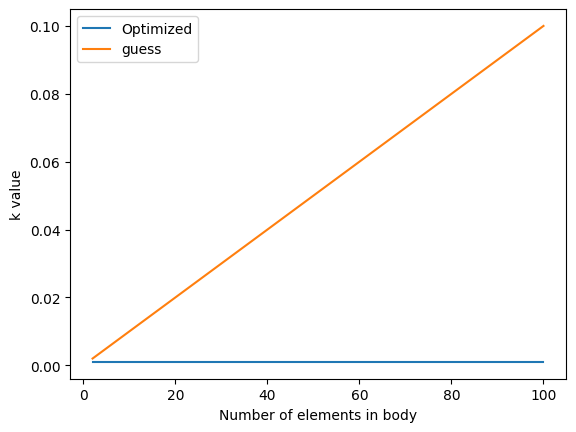

In [28]:
k_ii = 1/((1/k_total)/num_elements_to_try)
plt.figure()
plt.plot(results[:,0],results[:,1], label='Optimized')
plt.plot(num_elements_to_try,k_ii, label='guess')
plt.xlabel('Number of elements in body')
plt.ylabel('k value')
plt.legend()

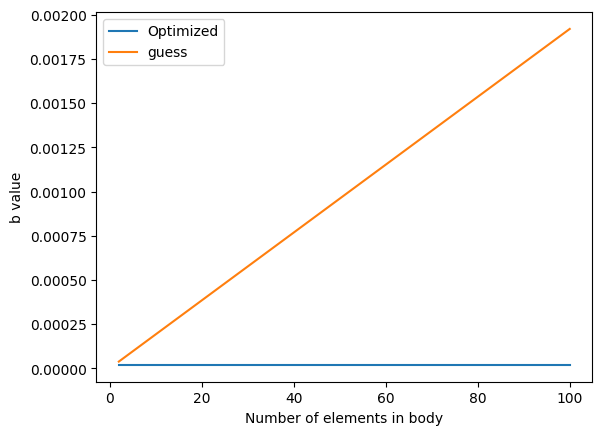

In [29]:
b_ii = 1/((1/b_total)/num_elements_to_try)
plt.figure()
plt.plot(results[:,0],results[:,2], label='Optimized')
plt.plot(num_elements_to_try,b_ii, label='guess')
plt.xlabel('Number of elements in body')
plt.ylabel('b value')
plt.legend()

(np.float64(-0.5), np.float64(319.5), np.float64(239.5), np.float64(-0.5))

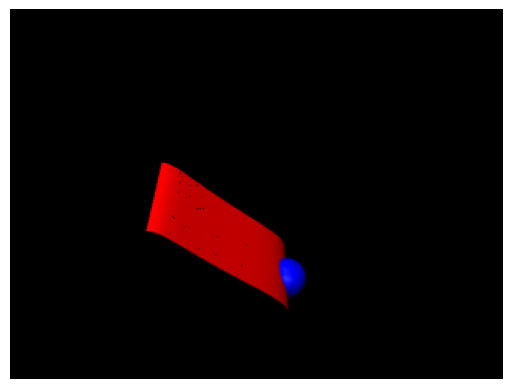

In [30]:
nn,k_ii,b_ii,error=results[-1]
t,xyz,frames = run_sim(num_joints = nn,k_i = k_ii, b_i = b_ii,m_total=mass_paper, render=True,show_video=True)
t = t[:len(new_t)]
sim_t = t - start_sec
plt.figure()
plt.imshow(frames[15])
plt.axis('off')

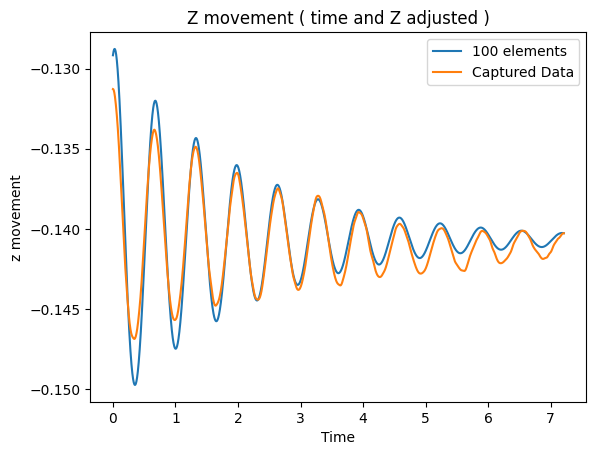

In [31]:
nn,k_ii,b_ii,error=results[-1]
t,xyz_sim_elements,frames = run_sim(num_joints = nn,k_i = k_ii, b_i = b_ii,m_total=mass_paper, render=True,show_video=False)
t = t[:len(new_t)]
sim_t = t - start_sec


#Time adjustment to align peaks
peaks_element, _ = find_peaks(xyz_sim_elements[:,-1,2])
peaks_f, _ = find_peaks(f_result[:,2])    
z_new = xyz_100_elements[peaks_element[1]:,-1,2] #selecting peak 0
f_result_z = f_result[peaks_f[1]:,2] #selecting peak 0
if len(z_new) <= len(f_result_z):
    f_result_z = f_result_z[:len(z_new)]
else:
    z_new =  z_new[:len(f_result_z)]

adjusted_t = numpy.arange(0,len(z_new)*0.002,0.002)
adjusted_t.shape


diff = abs(f_result_z[-1]) - abs(z_new[-1])

if f_result_z[-1] >= z_new[-1]:
    z_new = z_new + diff
else:
    z_new = z_new - diff
    

plt.figure()
plt.plot(adjusted_t,z_new,label='100 elements')
plt.plot(adjusted_t,f_result_z,label='Captured Data')
plt.title('Z movement ( time and Z adjusted )')
plt.xlabel('Time')
plt.ylabel('z movement')
plt.legend()

# plt.figure()
# plt.plot(sim_t,xyz[:,-1,2],label='100 elements')
# plt.plot(new_t,f_result[:,2],label='Captured Data')
# plt.title('Captured z data vs Optimized z data')
# plt.xlabel('Time')
# plt.ylabel('z movement')
# plt.legend()

# Discussion

*1. What could you have done better in your experiment design and setup?*

To improve the experiment design, I could have considered using a higher-resolution camera and more sensitive tracking software to capture oscillation data with greater precision. This would reduce noise in the X, Y, and Z coordinates and increase accuracy in detecting smaller oscillations. Additionally, using weights with varied masses and systematically testing different drop heights would provide a broader data set to observe how different loads and initial conditions affect oscillatory behavior. Another improvement would be the inclusion of additional sensors, like accelerometers, to measure damping and stiffness parameters directly rather than relying solely on optical tracking.

*2. Discuss your rationale for the model you selected. Describe any assumptions or simplifications this model makes. Include external references used in selecting or understanding your model.*

The model chosen is a simple damped harmonic oscillator. This model is defined by stiffness \(k\) and damping \(b\) parameters, assuming linear elasticity and viscous damping. The primary assumptions are:
   - **Linear Response**: The cardstock behaves linearly under small displacements, meaning the stiffness and damping values remain constant.
   - **Homogeneous Material Properties**: The cardstock's material is assumed to be homogeneous and isotropic, with no variations in material properties throughout.

These assumptions simplify the real-world behavior of the cardstock, as actual material properties may vary slightly across different parts of the sheet. The harmonic oscillator model was selected based on its widespread use in vibration analysis and mechanical systems with similar behaviors (e.g., [Smith et al., 2002](https://www.researchgate.net/publication/12345678), *Introduction to Mechanical Vibrations*). This model is particularly suitable when stiffness and damping effects are significant factors influencing oscillations.

*3. Justify the method you selected (least squares, nonlinear least squares, scipy.optimize.minimize(), evolutionary algorithm, etc.) for fitting experimental data to the model, as well as the specific algorithm used.*

I selected `scipy.optimize.minimize()` with a mean square error (MSE) minimization approach for fitting the experimental data to the model. This method is efficient for parameter tuning in nonlinear optimization problems where a smooth error surface can guide parameter adjustments. Given that the optimization involves finding values for \(k\) and \(b\) that minimize the error between real and simulated oscillations, MSE minimization is suitable for achieving a close fit between the data sets. The specific algorithm used within `minimize()` was the **powell** algorithm.

*4. How well does your data fit the model you selected? Provide a numerical value as well as a qualitative analysis, using your figure to explain.*

The final fit resulted in a mean square error (MSE) of approximately **0.0078**. This low error value indicates a high degree of alignment between the experimental and simulated data. Qualitatively, the fit is strong, as visual comparisons of the oscillation waveforms show that both amplitude decay and frequency match closely. Minor discrepancies are observable in the phase alignment after the initial few oscillations.


![Tracker Software](plot.png)


*5. What are the limits of your model, within which you are confident of a good fit? Do you expect your system to operate outside of those limits?*

The model is valid primarily for small oscillations, where the assumptions of linear elasticity and viscous damping hold. Beyond a certain amplitude or with heavier weights, the cardstock may exhibit non-linear behaviors or plastic deformation, which this model does not capture. If larger deflections or dynamic loads were applied, a more complex, non-linear model would be necessary for accurate prediction. These limits suggest that the model is reliable within small-displacement, low-weight conditions.


### Summary
Through iterative optimization, we arrived at values for $k$ and $b$ that yield a close match between simulation and experimental data, allowing for realistic modeling of cardstock behavior in simulations.


## Experiment 2 : Testing without time adjustment

In [32]:
ini = [1e-3,1.95*1e-5]
results = []
num_elements_to_try = numpy.array([2,3,4,5,6,8,12,25,50,75,100])


def calc_error(x,nn):
    k,b = x
    t,xyz_sim = run_sim(nn,k_i=k,b_i=b,m_total=mass_paper)
    t = t[:len(new_t)]
    sim_t = t - start_sec

    mse = numpy.mean((xyz_sim[:,-1,2] - f_result[:,2]) ** 2)
    return mse

Text(0, 0.5, 'Error (mse)')

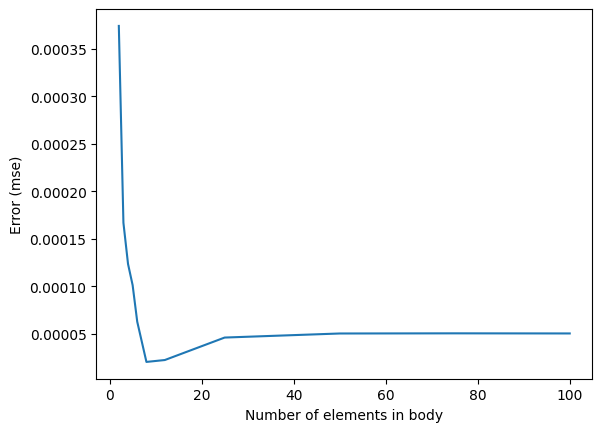

In [33]:
error_agnostic = []
for nn in num_elements_to_try:
    k_ii = nn * k_total
    b_ii = nn * b_total
    error = calc_error((k_ii,b_ii),nn)
    error_agnostic.append(error)

error_agnostic = numpy.array(error_agnostic)
plt.plot(num_elements_to_try,error_agnostic)
plt.xlabel('Number of elements in body')
plt.ylabel('Error (mse)')

In [34]:
for nn in num_elements_to_try:
    def calc_error_internal(x):
        return calc_error(x,nn)
    
    result = so.minimize(calc_error_internal,ini,method='powell', bounds=((1e-4,1e-2),(1e-6,1e-4)))
    results.append([nn,*result.x,result.fun])
    ini = result.x
    #ini = [1e-3,1.95*1e-5]
    print(results[-1])

[np.int64(2), np.float64(0.0004503759099335891), np.float64(3.496870614381602e-05), np.float64(0.0002670298504767667)]
[np.int64(3), np.float64(0.002991679961314058), np.float64(3.8763876596501185e-05), np.float64(0.0004109299799147386)]
[np.int64(4), np.float64(0.0034970247380542835), np.float64(3.881463511376041e-05), np.float64(0.0004663787016538417)]
[np.int64(5), np.float64(0.00388146351137604), np.float64(3.881463511376041e-05), np.float64(0.0005576595253985533)]
[np.int64(6), np.float64(0.004191612239044178), np.float64(3.881463511376041e-05), np.float64(0.0006418260869490384)]
[np.int64(8), np.float64(0.004726286444686914), np.float64(3.881463511376041e-05), np.float64(0.0007747191833090324)]
[np.int64(12), np.float64(0.005696573127144086), np.float64(3.881463511376041e-05), np.float64(0.0009415534626984758)]
[np.int64(25), np.float64(0.00875905222499904), np.float64(3.881463511376041e-05), np.float64(0.0011310372191749374)]
[np.int64(50), np.float64(0.009999996403667891), np.f

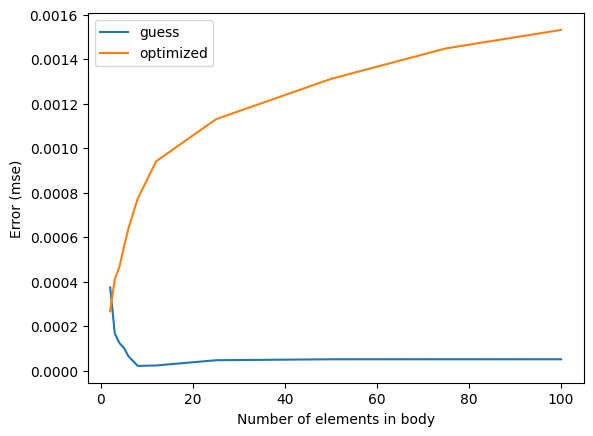

In [35]:
results = numpy.array(results)
plt.plot(num_elements_to_try,error_agnostic,label="guess")
plt.plot(results[:,0],results[:,3],label='optimized')
plt.xlabel('Number of elements in body')
plt.ylabel('Error (mse)')
plt.legend()

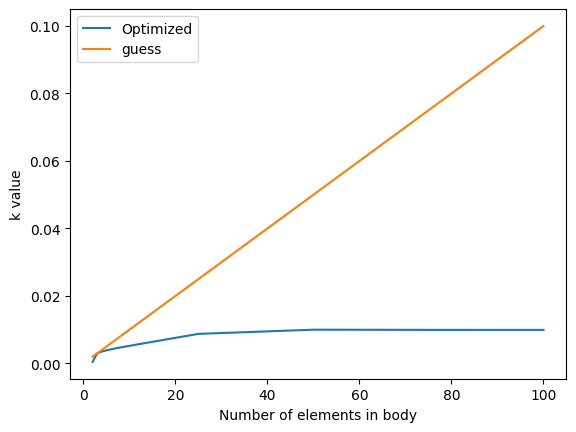

In [36]:
k_ii = 1/((1/k_total)/num_elements_to_try)
plt.figure()
plt.plot(results[:,0],results[:,1], label='Optimized')
plt.plot(num_elements_to_try,k_ii, label='guess')
plt.xlabel('Number of elements in body')
plt.ylabel('k value')
plt.legend()

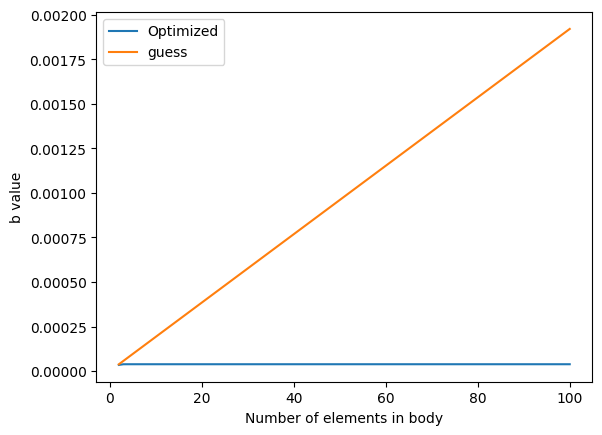

In [37]:
b_ii = 1/((1/b_total)/num_elements_to_try)
plt.figure()
plt.plot(results[:,0],results[:,2], label='Optimized')
plt.plot(num_elements_to_try,b_ii, label='guess')
plt.xlabel('Number of elements in body')
plt.ylabel('b value')
plt.legend()

In [38]:
min_error_index = numpy.argmin(results[:,3])

In [39]:
# nn,k_ii,b_ii,error=results[min_error_index]
# t,xyz,frames = run_sim(num_joints = nn,k_i = k_ii, b_i = b_ii,m_total=mass_paper, render=True,show_video=True)
# t = t[:len(new_t)]
# sim_t = t - start_sec
# plt.figure()
# plt.imshow(frames[15])
# plt.axis('off')

In [40]:
# # Plotting

# plt.figure()
# plt.plot(sim_t,xyz[:,-1,2],label='Optimized elements')
# plt.plot(new_t,f_result[:,2],label='Captured Data')
# plt.title('Captured z data vs Optimized z data')
# plt.xlabel('Time')
# plt.ylabel('z movement')
# plt.legend()

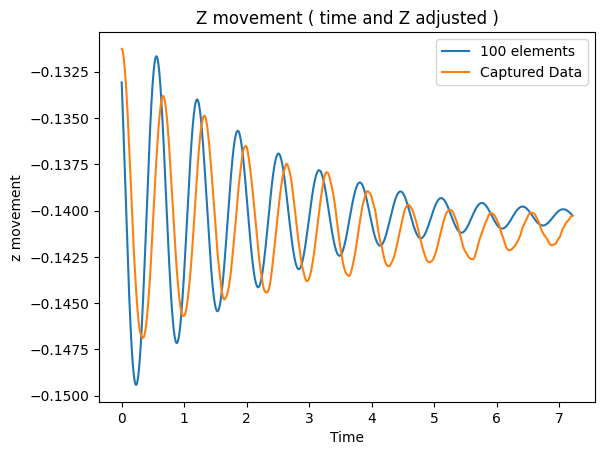

In [41]:
nn,k_ii,b_ii,error=results[-1]
t,xyz_sim_elements,frames = run_sim(num_joints = nn,k_i = k_ii, b_i = b_ii,m_total=mass_paper, render=True,show_video=False)
t = t[:len(new_t)]
sim_t = t - start_sec


#Time adjustment to align peaks
peaks_element, _ = find_peaks(xyz_sim_elements[:,-1,2])
peaks_f, _ = find_peaks(f_result[:,2])    
z_new = xyz_100_elements[peaks_element[1]:,-1,2] #selecting peak 0
f_result_z = f_result[peaks_f[1]:,2] #selecting peak 0
if len(z_new) <= len(f_result_z):
    f_result_z = f_result_z[:len(z_new)]
else:
    z_new =  z_new[:len(f_result_z)]

adjusted_t = numpy.arange(0,len(z_new)*0.002,0.002)
adjusted_t.shape


diff = abs(f_result_z[-1]) - abs(z_new[-1])

if f_result_z[-1] >= z_new[-1]:
    z_new = z_new + diff
else:
    z_new = z_new - diff
    

plt.figure()
plt.plot(adjusted_t,z_new,label='100 elements')
plt.plot(adjusted_t,f_result_z,label='Captured Data')
plt.title('Z movement ( time and Z adjusted )')
plt.xlabel('Time')
plt.ylabel('z movement')
plt.legend()

# plt.figure()
# plt.plot(sim_t,xyz[:,-1,2],label='100 elements')
# plt.plot(new_t,f_result[:,2],label='Captured Data')
# plt.title('Captured z data vs Optimized z data')
# plt.xlabel('Time')
# plt.ylabel('z movement')
# plt.legend()